# Land masks and release masks for dataset NWES
Notebook to create landmasks and release masks based on location and depth for the 
CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013 dataset. We create the following maps:
1. Landmask 
2. doggersbank release mask
3. Norwegian trench release mask
4. Norwegian trench hexagonal release
5. Complete NWES hexagonal release

In [1]:
#import packages
import os
import glob
import numpy as np
import xarray as xr
import scipy
import json
import pickle
from shapely.geometry import shape, Point
import matplotlib.pyplot as plt
import cartopy as cart
import h3
# from h3.unstable import vect  # used for hexgrid vectorization
import pickle

# import h3_tools written by Daan
import h3_tools

In [ ]:
h3.__version__
#version 4 used in the geo vonoroi analysis (srai) so updated this code to work with this version as well

'4.1.0b3'

## Release on lon-lat grid positions

In [2]:
# define needed functions   
def to_netcdf(output_filename,data,data_name,lons,lats,explanation=''):
    '''
    All data is written to netcdf files to speed up computations
    '''
    
    
    dict_data = {}
    for data_, name_ in zip(data,data_name):
        dict_data[name_] = (["x","y"], data_)
    dict_data['explanation'] = explanation
        
    dict_coords = {}
    dict_coords['lon'] = (["x","y"], lons)
    dict_coords['lat'] = (["x","y"], lats)   
  
    ds = xr.Dataset(
        dict_data,
        coords=dict_coords,
    )   
    ds.to_netcdf(output_filename)

def get_mask_land(field, lons, lats, outfile='./tmp_mask_land'):
    '''
    Mask with true on land cells, false on ocean cells
    '''
    if os.path.exists(outfile):
        ds = xr.open_dataset(outfile)
        mask_land = np.array(ds['mask_land'],dtype=bool)    
    else:
        mask_land = np.isnan(field)
        to_netcdf(outfile,[mask_land],['mask_land'],lons,lats,explanation='land mask')
    return mask_land

### Input masks files 
We need to create mask seperately for data before and after 01/09/2023   
as the grid resolution of the velocity field changes at this date

<xarray.Dataset> Size: 114MB
Dimensions:  (time: 24, lat: 1240, lon: 958)
Coordinates:
  * time     (time) datetime64[ns] 192B 2023-11-08T01:00:00 ... 2023-11-09
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
Data variables:
    zos      (time, lat, lon) float32 114MB ...
Attributes: (12/13)
    title:                hourly-instantaneous SSH (2D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    institution:          UK Met Office
    history:              See source and creation_date attributes
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    product:              NORTHWESTSHELF_ANALYSIS_FOREC

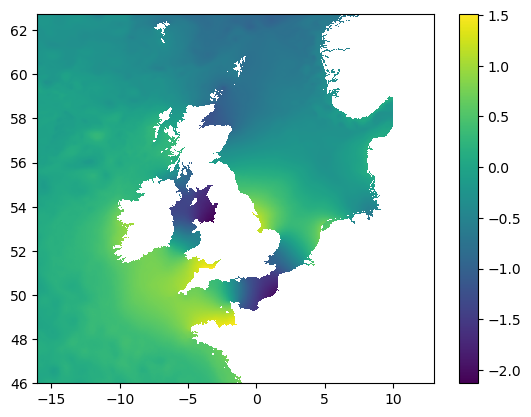

In [3]:
# make land mask for data before 01/09/2023
#use sea surface heigth to make mask
input_file = '/storage/shared/oceanparcels/input_data/CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/metoffice_foam1_amm15_NWS_SSH_b20231106_hi20231108.nc' 
ds = xr.open_dataset(input_file)
print(ds)
lat=ds['lat'].values
lon=ds['lon'].values
ssh=ds['zos'].values[0,:,:]
grid=np.meshgrid(lon,lat)
longrid,latgrid=grid
print(ssh.shape)
fig,ax=plt.subplots()
psm=ax.pcolormesh(lon,lat,ssh,shading='nearest')
fig.colorbar(psm, ax=ax)
mask_land = get_mask_land(ssh, longrid, latgrid, outfile='/storage/shared/oceanparcels/output_data/data_Meike/NWES/NWS_mask_land_old.nc')


<xarray.Dataset> Size: 10GB
Dimensions:    (time: 24, longitude: 936, latitude: 551, depth: 50)
Coordinates:
  * time       (time) datetime64[ns] 192B 2023-12-04T00:30:00 ... 2023-12-04T...
  * longitude  (longitude) float32 4kB -16.0 -15.97 -15.94 ... 9.921 9.949 9.977
  * latitude   (latitude) float32 2kB 46.0 46.03 46.06 ... 61.23 61.25 61.28
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
Data variables:
    uo         (time, depth, latitude, longitude) float32 2GB ...
    vo         (time, depth, latitude, longitude) float32 2GB ...
    thetao     (time, depth, latitude, longitude) float32 2GB ...
    so         (time, depth, latitude, longitude) float32 2GB ...
Attributes: (12/13)
    Conventions:     CF-1.8
    title:           Ocean 3D hourly mean fields for the North West Shelf (NW...
    source:          NEMO3.6
    domain_name:     NWS36
    field_type:      mean
    field_date:      20231204
    ...              ...
    forecast_type:   hindcas

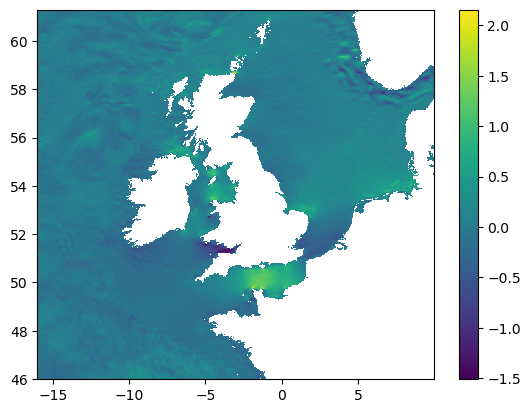

In [6]:
# make land mask for data after 01/09/2023
input_file = '/storage/shared/oceanparcels/input_data/CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/CMEMS_v6r1_NWS_PHY_NRT_NL_01hav3D_20231204_20231204_R20231205_HC01.nc' 
ds = xr.open_dataset(input_file)
print(ds)
lat=ds['latitude'].values
lon=ds['longitude'].values

ssh=ds['uo'].values[0,0,:,:]
grid=np.meshgrid(lon,lat)
longrid,latgrid=grid
print(ssh.shape)
fig,ax=plt.subplots()
psm=ax.pcolormesh(lon,lat,ssh,shading='nearest')
fig.colorbar(psm, ax=ax)
mask_land = get_mask_land(ssh, longrid, latgrid, outfile='/storage/shared/oceanparcels/output_data/data_Meike/NWES/NWS_mask_land_new.nc')

### make doggersbank release mask
We create the doggersbank release mask based on depth.   
We use a maximum depht of 30 m (29.444729 m) for the old (new) dataset.   
And a domain given by lon in (1, 4.2) and lat in (54.25, 55.5)  


In [ ]:
#plot field at given depth to see what is best definition
input_file = '/storage/shared/oceanparcels/input_data/CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/metoffice_foam1_amm15_NWS_CUR_b20231106_hi20231108.nc' 
ds = xr.open_dataset(input_file)

lat=ds['lat'].values
lon=ds['lon'].values
depth = ds['depth'].values
u = ds['uo'].values[0,7,:,:]
print(depth[7])
# ssh=ds['zos'].values[0,:,:]
grid=np.meshgrid(lon,lat)
longrid,latgrid=grid
# print(ssh.shape)
fig,ax=plt.subplots()
psm=ax.pcolormesh(lon[500:700],lat[500:1000],u[500:1000,500:700],shading='nearest')
print(depth[10])
# fig.colorbar(psm, ax=ax)

<xarray.Dataset> Size: 8GB
Dimensions:  (time: 24, lat: 1240, lon: 958, depth: 33)
Coordinates:
  * time     (time) datetime64[ns] 192B 2023-11-08T01:00:00 ... 2023-11-09
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
Data variables:
    uo       (time, depth, lat, lon) float32 4GB ...
    vo       (time, depth, lat, lon) float32 4GB ...
Attributes: (12/13)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    institution:          UK Met Office
    history:              See source and

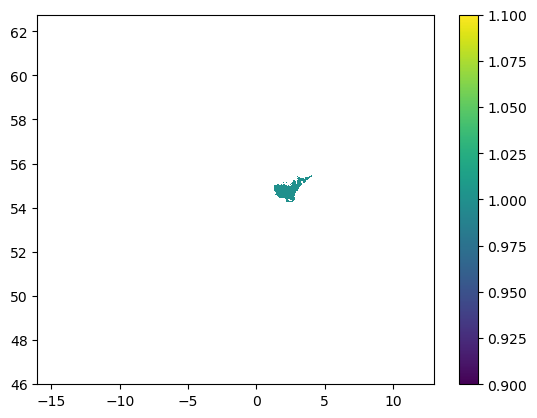

In [41]:
# create doggersbank for old data
input_file = '/storage/shared/oceanparcels/input_data/CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/metoffice_foam1_amm15_NWS_CUR_b20231106_hi20231108.nc' 
ds = xr.open_dataset(input_file)
print(ds)

lat=ds['lat'].values
lon=ds['lon'].values
depth = ds['depth'].values
zindex = 7
print(depth[zindex])
u = ds['uo'].values[0,zindex,:,:]

grid=np.meshgrid(lon,lat)
longrid,latgrid=grid

doggersbank = np.zeros((lat.size,lon.size))+1
# use land mask at detph
doggersbank=doggersbank*np.isnan(u)
# select area around doggersbank
doggersbank[longrid<1] =2
doggersbank[longrid>4.2] =2
doggersbank[latgrid>55.5] =2
doggersbank[latgrid<54.25] =2
# set only doggersbank to non nan
doggersbank[doggersbank == 0] = 2
doggersbank[doggersbank ==2] = np.nan

fig,ax=plt.subplots()
psm=ax.pcolormesh(lon,lat,doggersbank,shading='nearest')
fig.colorbar(psm, ax=ax)
#ax.set_xlim(0,5)
#ax.set_ylim(54,56)
# save mask doggersbank
mask_doggersbank = get_mask_land(doggersbank, longrid, latgrid, outfile='/storage/shared/oceanparcels/output_data/data_Meike/NWES/NWS_mask_doggersbank_old.nc')


<xarray.Dataset> Size: 10GB
Dimensions:    (time: 24, longitude: 936, latitude: 551, depth: 50)
Coordinates:
  * time       (time) datetime64[ns] 192B 2023-12-04T00:30:00 ... 2023-12-04T...
  * longitude  (longitude) float32 4kB -16.0 -15.97 -15.94 ... 9.921 9.949 9.977
  * latitude   (latitude) float32 2kB 46.0 46.03 46.06 ... 61.23 61.25 61.28
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
Data variables:
    uo         (time, depth, latitude, longitude) float32 2GB ...
    vo         (time, depth, latitude, longitude) float32 2GB ...
    thetao     (time, depth, latitude, longitude) float32 2GB ...
    so         (time, depth, latitude, longitude) float32 2GB ...
Attributes: (12/13)
    Conventions:     CF-1.8
    title:           Ocean 3D hourly mean fields for the North West Shelf (NW...
    source:          NEMO3.6
    domain_name:     NWS36
    field_type:      mean
    field_date:      20231204
    ...              ...
    forecast_type:   hindcas

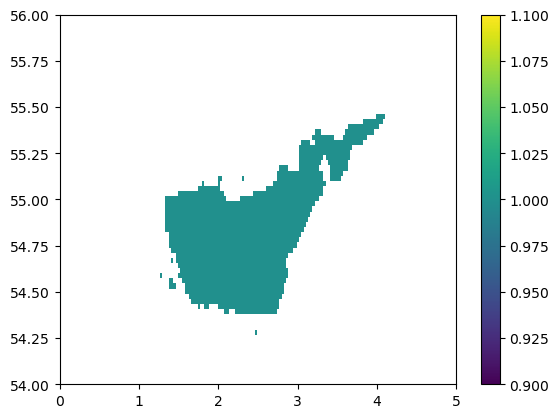

In [42]:
# set doggersbank
input_file = '/storage/shared/oceanparcels/input_data/CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/CMEMS_v6r1_NWS_PHY_NRT_NL_01hav3D_20231204_20231204_R20231205_HC01.nc' 
ds = xr.open_dataset(input_file)
print(ds)
lat = ds['latitude'].values
lon = ds['longitude'].values
depth = ds['depth'].values
zindex = 14
print(depth[zindex])
u = ds['uo'].values[0,zindex,:,:]

grid = np.meshgrid(lon,lat)
longrid, latgrid = grid

doggersbank = np.zeros((lat.size,lon.size))+1
# use land mask at detph
doggersbank = doggersbank*np.isnan(u)
# select area around doggersbank
doggersbank[longrid<1] = 2
doggersbank[longrid>4.2] = 2
doggersbank[latgrid>55.5] = 2
doggersbank[latgrid<54.25] = 2
# set only doggersbank to non nan
doggersbank[doggersbank == 0] = 2
doggersbank[doggersbank ==2] = np.nan

fig,ax=plt.subplots()
psm=ax.pcolormesh(lon, lat, doggersbank, shading='nearest')
fig.colorbar(psm, ax=ax)
ax.set_xlim(0,5)
ax.set_ylim(54,56)
# save mask doggersbank
mask_doggersbank = get_mask_land(doggersbank, longrid, latgrid, outfile='/storage/shared/oceanparcels/output_data/data_Meike/NWES/NWS_mask_doggersbank_new.nc')

### create norwegian trench release mask
we create the norwegian trench release mask based on depth as well. 
We keep everything at the norwegian coast (west of 3.1 lon) at and
 below 150 m (155.85072 m) for the old (new) dataset.

(551, 936)
155.85072


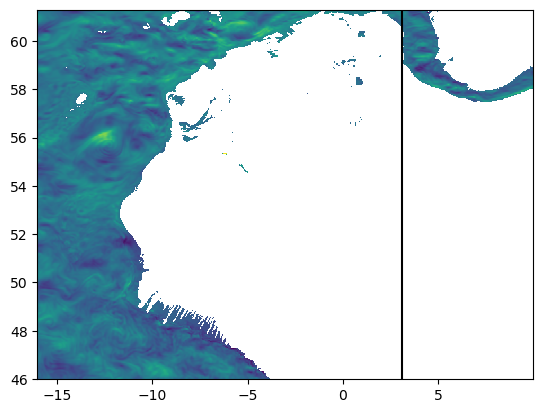

In [35]:
#plot field at given depth to see what is best definition
input_file = '/storage/shared/oceanparcels/input_data/CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/CMEMS_v6r1_NWS_PHY_NRT_NL_01hav3D_20231204_20231204_R20231205_HC01.nc' 
ds = xr.open_dataset(input_file)
zindex=24
lat=ds['latitude'].values
lon=ds['longitude'].values
depth = ds['depth'].values
u = ds['uo'].values[0,zindex,:,:]
print(u.shape)
# ssh=ds['zos'].values[0,:,:]
grid=np.meshgrid(lon,lat)
longrid,latgrid=grid
# print(ssh.shape)
fig,ax=plt.subplots()
psm=ax.pcolormesh(lon,lat,u,shading='nearest')
print(depth[zindex])
ax.axvline(3.1,color='black')
# fig.colorbar(psm, ax=ax)

150.0


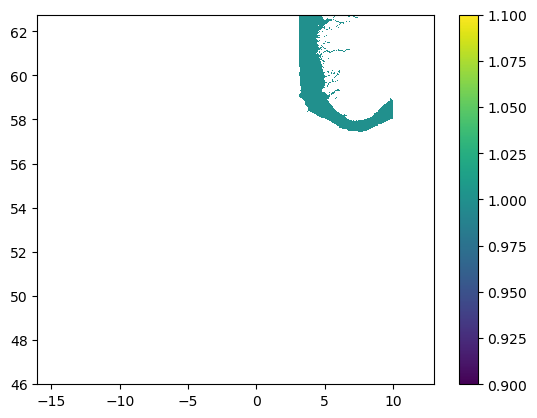

In [43]:
# create norwegian trench mask for old data
input_file = '/storage/shared/oceanparcels/input_data/CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/metoffice_foam1_amm15_NWS_CUR_b20231106_hi20231108.nc' 
ds = xr.open_dataset(input_file)

lat=ds['lat'].values
lon=ds['lon'].values
depth = ds['depth'].values
zindex = 14
print(depth[zindex])
u = ds['uo'].values[0,zindex,:,:]

grid=np.meshgrid(lon,lat)
longrid,latgrid=grid

Norwegian_trench = np.zeros((lat.size,lon.size))+1
# use land mask at detph
Norwegian_trench=Norwegian_trench*(~np.isnan(u))
# select area around norwegian trench
Norwegian_trench[longrid<3.1] =2
Norwegian_trench[latgrid<56] =2
# set only doggersbank to non nan
Norwegian_trench[Norwegian_trench == 0] = 2
Norwegian_trench[Norwegian_trench == 2] = np.nan

fig,ax=plt.subplots()
psm=ax.pcolormesh(lon,lat,Norwegian_trench,shading='nearest')
fig.colorbar(psm, ax=ax)

# save mask Norwegian Trench
mask_Norwegian_trench = get_mask_land(Norwegian_trench, longrid, latgrid, outfile='/storage/shared/oceanparcels/output_data/data_Meike/NWES/NWS_mask_norwegian_trench_old.nc')


155.85072


NameError: name 'get_mask_land' is not defined

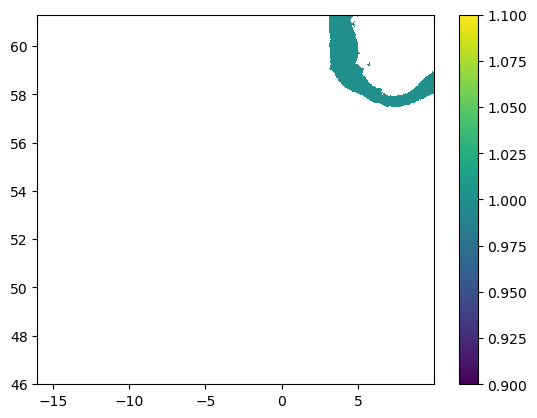

In [37]:
# create norwegian trench mask for new data
input_file = '/storage/shared/oceanparcels/input_data/CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/CMEMS_v6r1_NWS_PHY_NRT_NL_01hav3D_20231204_20231204_R20231205_HC01.nc' 

lat=ds['latitude'].values
lon=ds['longitude'].values
depth = ds['depth'].values
zindex = 24
print(depth[zindex])
u = ds['uo'].values[0,zindex,:,:]

grid=np.meshgrid(lon,lat)
longrid,latgrid=grid

Norwegian_trench = np.zeros((lat.size,lon.size))+1
# use land mask at detph
Norwegian_trench=Norwegian_trench*(~np.isnan(u))
# select area around norwegian trench
Norwegian_trench[longrid<3.1] =2
Norwegian_trench[latgrid<56] =2
# set only doggersbank to non nan
Norwegian_trench[Norwegian_trench == 0] = 2
Norwegian_trench[Norwegian_trench == 2] = np.nan

fig,ax=plt.subplots()
psm=ax.pcolormesh(lon,lat,Norwegian_trench,shading='nearest')
fig.colorbar(psm, ax=ax)

# save mask Norwegian Trench
mask_Norwegian_trench = get_mask_land(Norwegian_trench, longrid, latgrid, outfile='/storage/shared/oceanparcels/output_data/data_Meike/NWES/NWS_mask_norwegian_trench_new.nc')


# hexagonal release Norwegian trench
Creating particle release location based on uber h3 release (hexagonal release)  
From daans code: https://github.com/OceanParcels/Lagrangian_diags/blob/dev-Daan/Preparation/initialize_h3_particles.ipynb   
We use  https://geojson.io/#map=1.77/17.4/-63/8.8/18 to select the region of interest (roughly)

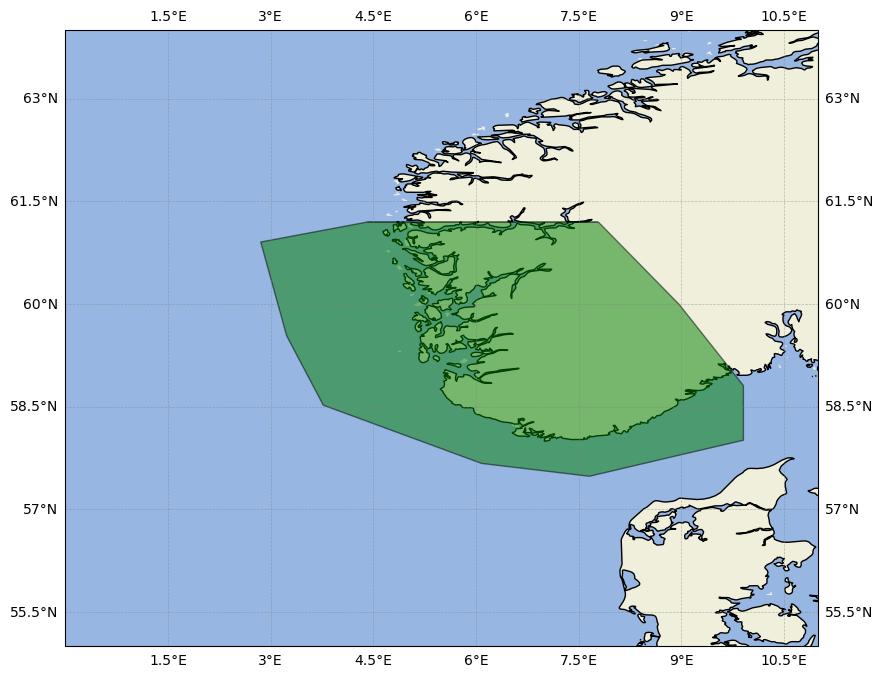

In [3]:
# hexagonal release region definition (without filtering out land)
Norwegian_Trench = { 
    "type":"Polygon",
    "coordinates": [
        [[9.9,58.812245439467716],
         [8.961956413749505,59.99781194853341],
         [7.7829521368111045,61.2],
         [4.392938844394649,61.2],
         [2.847852434980439,60.91029980195512],
         [3.22632830214593,59.5409928174447],
         [3.7617441607360433,58.526743354523546],
         [6.073093374922422,57.67601026303126],
         [7.650256134169524,57.48804264877376],
         [8.877699446012201,57.77676547517024],
         [9.9,58.01489616843355],
         [9.9,58.812245439467716]
         ]]}



Norwegian_Trench_Flipped = {
      "type": "Polygon",
      "coordinates": [[[lat, lon] for lon, lat in Norwegian_Trench["coordinates"][0]]]}

# plot selected region
NT_shape = shape(Norwegian_Trench)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)
ax.add_geometries([NT_shape], cart.crs.PlateCarree(), facecolor='green', edgecolor='black', alpha=0.5)
ax.set_xlim(0,11)
ax.set_ylim(55,64)
plt.show()


4686


### set particles for old dataset

4686


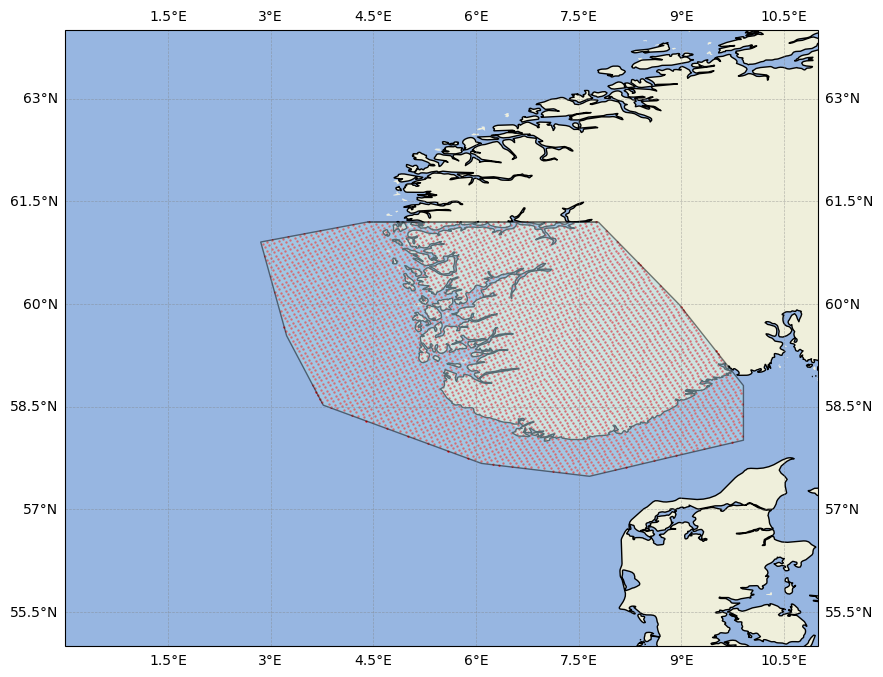

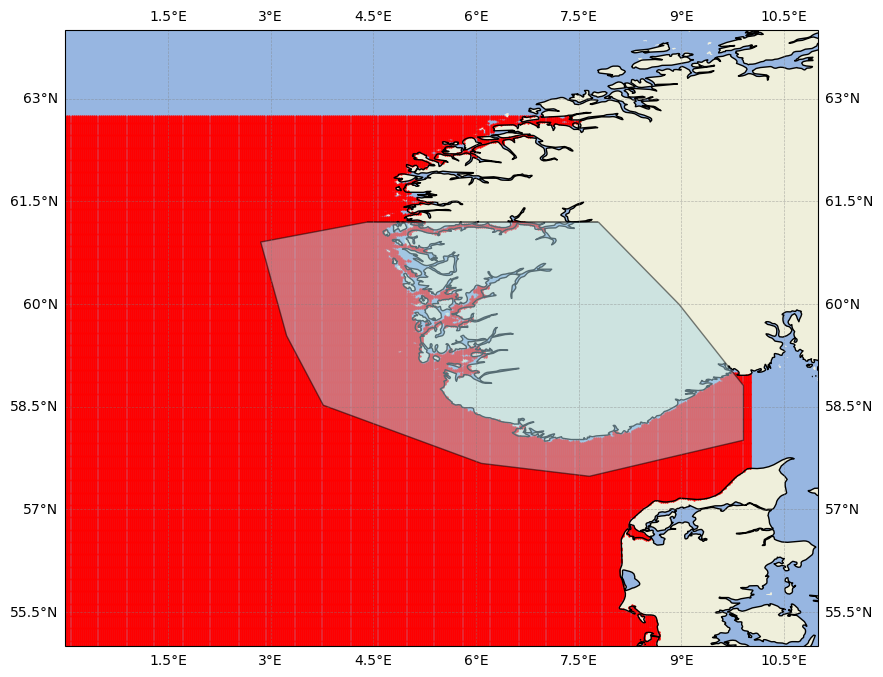

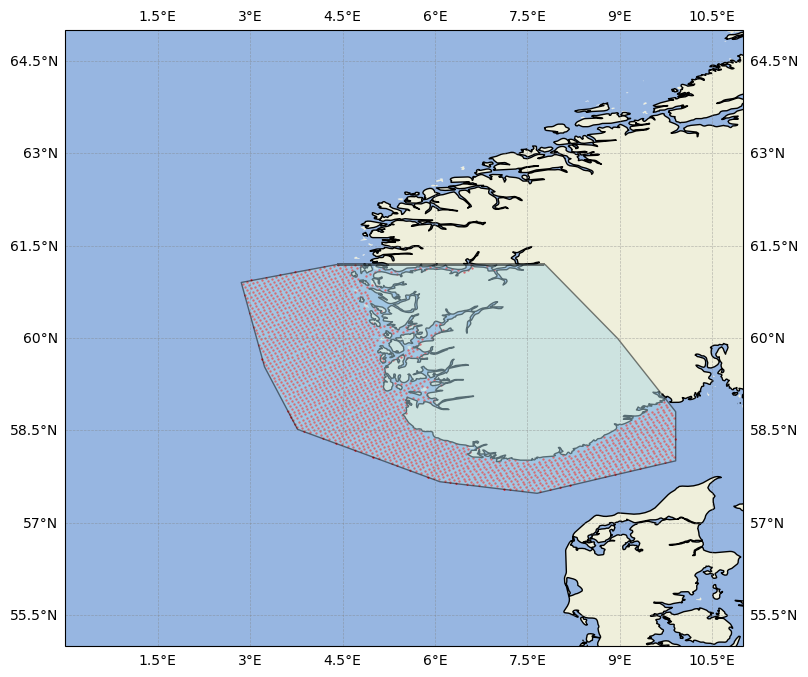

Number of particles: 2080


In [68]:
# set particles on hexagonal grid in region
NorwegianTrenchParticles = h3_tools.initGrid(Norwegian_Trench_Flipped, h3_res=6)
print(NorwegianTrenchParticles.centroid_lons.size)

# plot partciles together with region
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)

ax.scatter(NorwegianTrenchParticles.centroid_lons, NorwegianTrenchParticles.centroid_lats, transform=cart.crs.PlateCarree(), s=0.5, c='r')
ax.add_geometries([NT_shape], cart.crs.PlateCarree(), facecolor='lightblue', edgecolor='black', alpha=0.5)
ax.set_xlim(0,11)
ax.set_ylim(55,64)

plt.show()

#set mask for old dataset
mask = xr.open_dataset('/storage/shared/oceanparcels/input_data/CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/metoffice_foam1_amm15_NWS_CUR_b20231106_hi20231108.nc' ).isel(time=0).isel(depth=0)
lats, lons = np.meshgrid(mask.lat.values,mask.lon.values,indexing='ij') 
full_water =~np.isnan(mask.uo.values.T)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)

ax.scatter(lons[full_water.T], lats[full_water.T], transform=cart.crs.PlateCarree(), s=0.5, c='r')
ax.add_geometries([NT_shape], cart.crs.PlateCarree(), facecolor='lightblue', edgecolor='black', alpha=0.5)
ax.set_xlim(0,11)
ax.set_ylim(55,64)

plt.show()

# use mask on particles
NorwegianTrenchParticles.mask(lons, lats, full_water.T)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)

ax.scatter(NorwegianTrenchParticles.centroid_lons, NorwegianTrenchParticles.centroid_lats, transform=cart.crs.PlateCarree(), s=0.5, c='r')
ax.add_geometries([NT_shape], cart.crs.PlateCarree(), facecolor='lightblue', edgecolor='black', alpha=0.5)

ax.set_xlim(0,11)
ax.set_ylim(55,65)

plt.show()
print(f"Number of particles: {NorwegianTrenchParticles.size}")

In [69]:
# save particles
dict=NorwegianTrenchParticles.lonlat_dict
dict['region'] = 'Norwegian trench'
ds = xr.Dataset(
        dict
    )   
print(ds)
ds.to_netcdf('/storage/shared/oceanparcels/output_data/data_Meike/NWES/NWS_hex_release_norwegian_trench_old.nc')




<xarray.Dataset> Size: 33kB
Dimensions:      (lon: 2080, lat: 2080)
Coordinates:
  * lon          (lon) float64 17kB 6.707 4.157 4.821 ... 5.012 4.832 3.675
  * lat          (lat) float64 17kB 57.92 59.47 60.23 58.64 ... 58.21 58.7 60.72
Data variables:
    uber_h3_res  int64 8B 6
    region       <U16 64B 'Norwegian trench'


### set particles for new dataset

4686


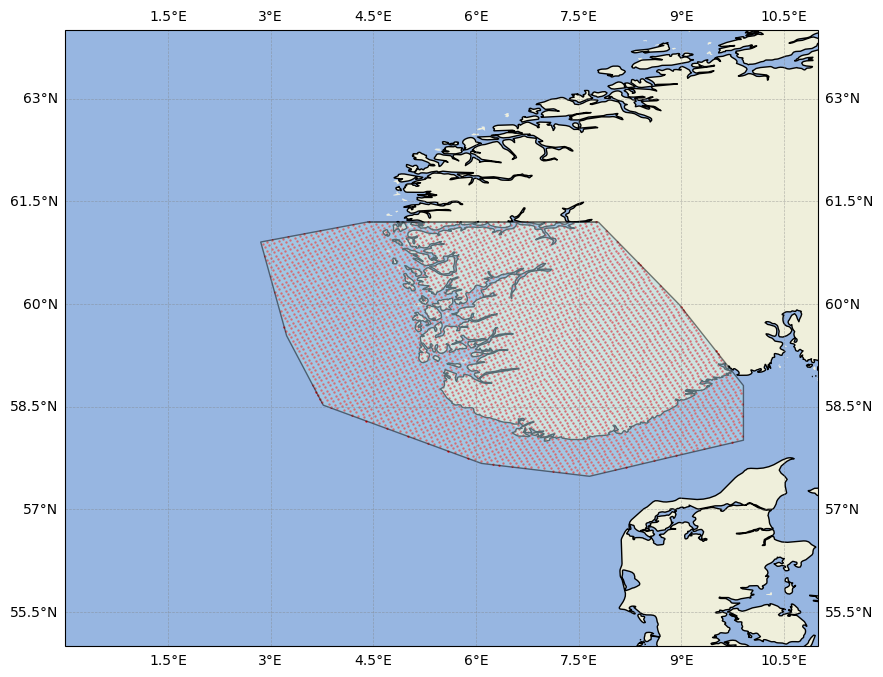

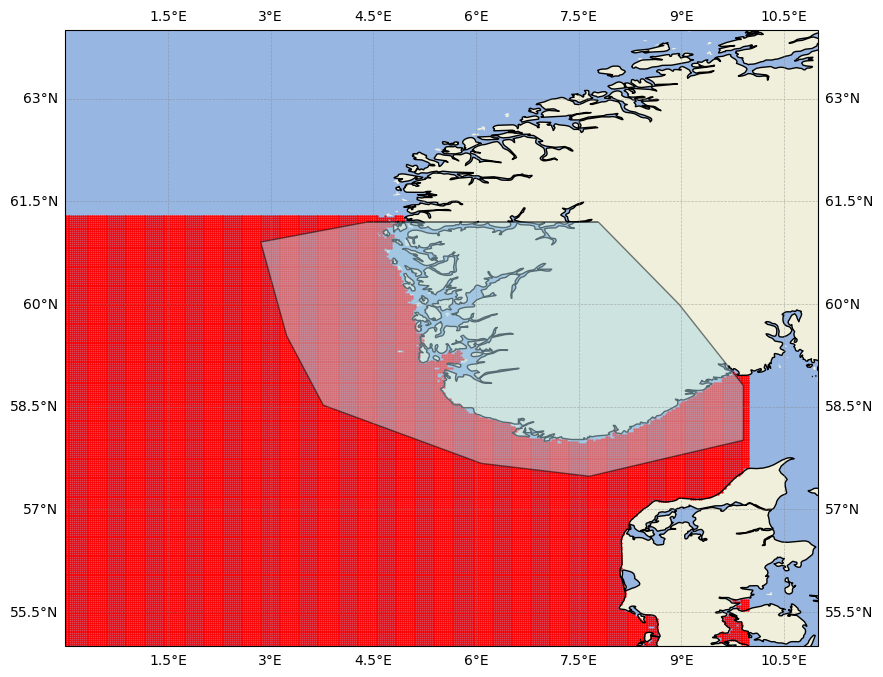

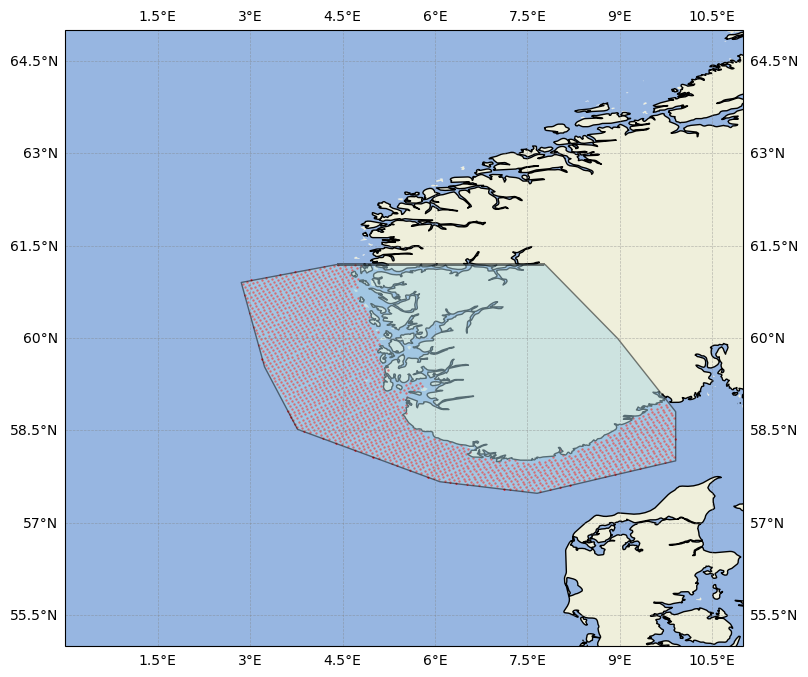

Number of particles: 1961


In [66]:
# set particles on hexagonal grid in region
NorwegianTrenchParticles = h3_tools.initGrid(Norwegian_Trench_Flipped, h3_res=6)
print(NorwegianTrenchParticles.centroid_lons.size)

# plot partciles together with region
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)

ax.scatter(NorwegianTrenchParticles.centroid_lons, NorwegianTrenchParticles.centroid_lats, transform=cart.crs.PlateCarree(), s=0.5, c='r')
ax.add_geometries([NT_shape], cart.crs.PlateCarree(), facecolor='lightblue', edgecolor='black', alpha=0.5)
ax.set_xlim(0,11)
ax.set_ylim(55,64)

plt.show()

#set mask for new dataset
mask = xr.open_dataset('/storage/shared/oceanparcels/input_data/CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/CMEMS_v6r1_NWS_PHY_NRT_NL_01hav3D_20231204_20231204_R20231205_HC01.nc').isel(time=0).isel(depth=0)
lats, lons = np.meshgrid(mask.latitude.values,mask.longitude.values,indexing='ij') 
full_water =~np.isnan(mask.uo.values.T)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)

ax.scatter(lons[full_water.T], lats[full_water.T], transform=cart.crs.PlateCarree(), s=0.5, c='r')
ax.add_geometries([NT_shape], cart.crs.PlateCarree(), facecolor='lightblue', edgecolor='black', alpha=0.5)
ax.set_xlim(0,11)
ax.set_ylim(55,64)

plt.show()

# use mask on particles
NorwegianTrenchParticles.mask(lons, lats, full_water.T)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)

ax.scatter(NorwegianTrenchParticles.centroid_lons, NorwegianTrenchParticles.centroid_lats, transform=cart.crs.PlateCarree(), s=0.5, c='r')
ax.add_geometries([NT_shape], cart.crs.PlateCarree(), facecolor='lightblue', edgecolor='black', alpha=0.5)

ax.set_xlim(0,11)
ax.set_ylim(55,65)

plt.show()
print(f"Number of particles: {NorwegianTrenchParticles.size}")

In [67]:
# save particles
dict=NorwegianTrenchParticles.lonlat_dict
dict['region'] = 'Norwegian trench'
ds = xr.Dataset(
        dict
    )   
print(ds)
ds.to_netcdf('/storage/shared/oceanparcels/output_data/data_Meike/NWES/NWS_hex_release_norwegian_trench_new.nc')





<xarray.Dataset> Size: 31kB
Dimensions:      (lon: 1961, lat: 1961)
Coordinates:
  * lon          (lon) float64 16kB 6.707 4.157 4.821 ... 5.012 4.832 3.675
  * lat          (lat) float64 16kB 57.92 59.47 60.23 58.64 ... 58.21 58.7 60.72
Data variables:
    uber_h3_res  int64 8B 6
    region       <U16 64B 'Norwegian trench'


# Hexagonal release NWES 


-15.996014595031738
46.00364303588867
61.28188705444336
9.977004051208496


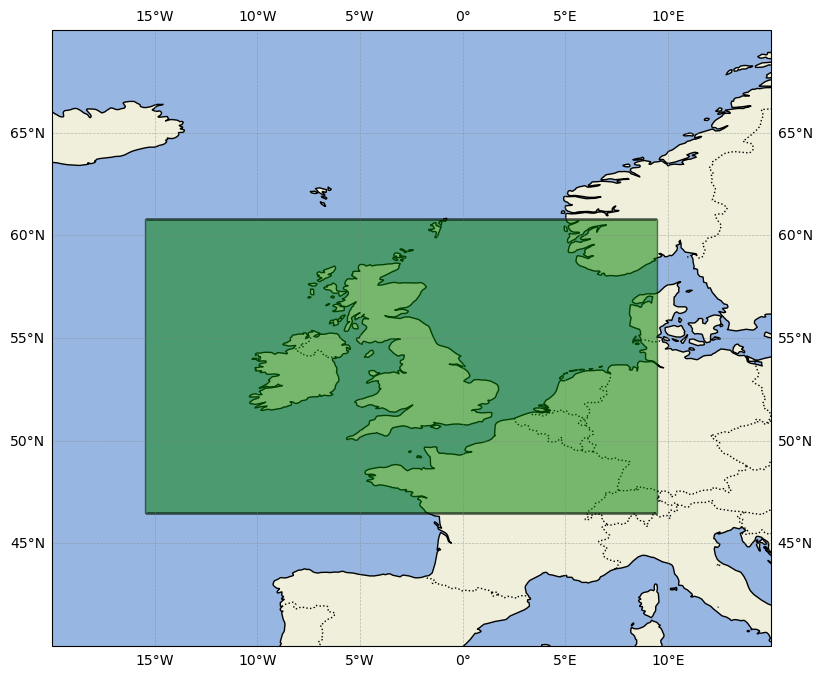

In [2]:
mask = xr.open_dataset('/storage/shared/oceanparcels/input_data/CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/CMEMS_v6r1_NWS_PHY_NRT_NL_01hav3D_20231204_20231204_R20231205_HC01.nc').isel(time=0).isel(depth=0)
lonmin = mask['longitude'].min().values
lonmax = mask['longitude'].max().values
latmin = mask['latitude'].min().values
latmax = mask['latitude'].max().values
print(lonmin)
print(latmin)
print(latmax)
print(lonmax)
NWES_domain = { 
    "type":"Polygon",
    "coordinates": [
   [[9.977004051208496-0.5,61.28188705444336-0.5],
     [-15.996014595031738+0.5,61.28188705444336-0.5],
     [-15.996014595031738+0.5,46.00364303588867+0.5],
     [9.977004051208496-0.5,46.00364303588867+0.5],
     [9.977004051208496-0.5,61.28188705444336-0.5]]
     ]}

NWES_domain_Flipped = {
      "type": "Polygon",
      "coordinates": [[[lat, lon] for lon, lat in NWES_domain["coordinates"][0]]]}

# plot selected region
NWES_shape = shape(NWES_domain)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)
ax.add_geometries([NWES_shape], cart.crs.PlateCarree(), facecolor='green', edgecolor='black', alpha=0.5)
ax.set_xlim(-20,15)
ax.set_ylim(40,70)
plt.show()

3.355759998880183
Number of particles: 136916


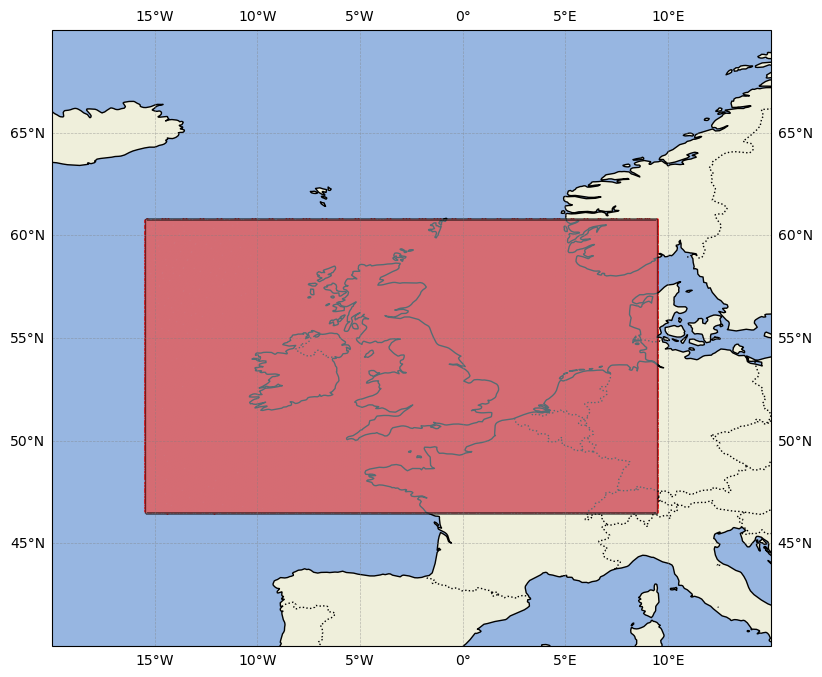

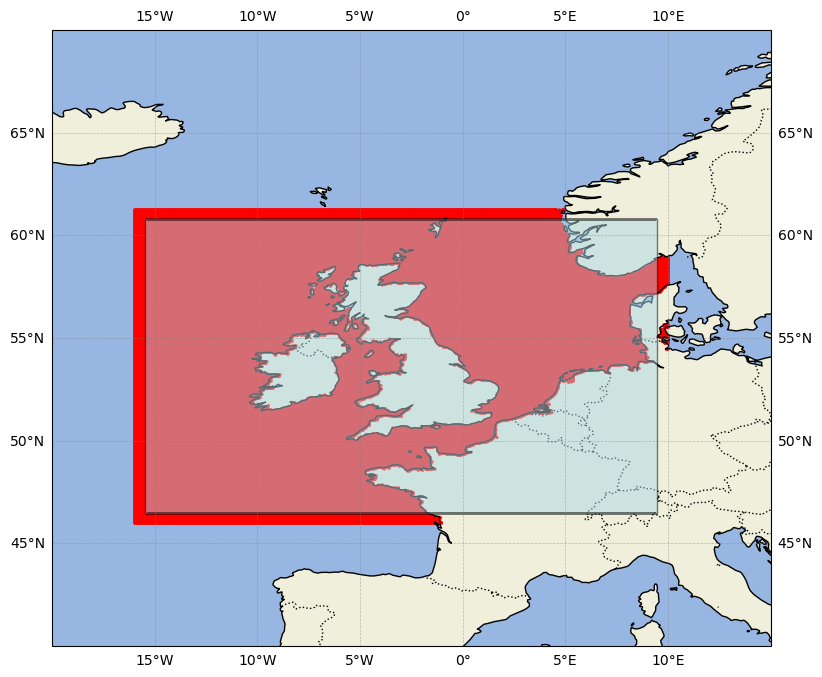

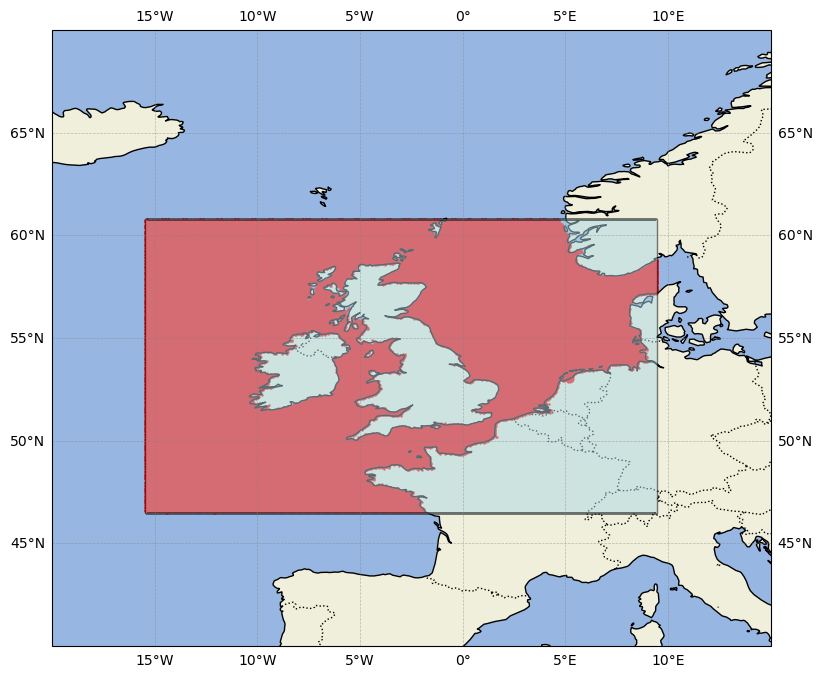

Number of particles: 88347


In [3]:
# set particles on hexagonal grid in region
NWESParticles = h3_tools.initGrid(NWES_domain_Flipped, h3_res=6)
print(NWESParticles.centroid_lons[0])
print(f"Number of particles: {NWESParticles.size}")

# plot partciles together with region
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)

ax.scatter(NWESParticles.centroid_lons, NWESParticles.centroid_lats, transform=cart.crs.PlateCarree(), s=0.5, c='r')
ax.add_geometries([NWES_shape], cart.crs.PlateCarree(), facecolor='lightblue', edgecolor='black', alpha=0.5)
ax.set_xlim(-20,15)
ax.set_ylim(40,70)

plt.show()

#set mask for new dataset
# mask = xr.open_dataset('/storage/shared/oceanparcels/input_data/CMEMS/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/CMEMS_v6r1_NWS_PHY_NRT_NL_01hav3D_20231204_20231204_R20231205_HC01.nc').isel(time=0).isel(depth=0)
lats, lons = np.meshgrid(mask.latitude.values,mask.longitude.values,indexing='ij') 
full_water =~np.isnan(mask.uo.values.T)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)

ax.scatter(lons[full_water.T], lats[full_water.T], transform=cart.crs.PlateCarree(), s=0.5, c='r')
ax.add_geometries([NWES_shape], cart.crs.PlateCarree(), facecolor='lightblue', edgecolor='black', alpha=0.5)
ax.set_xlim(-20,15)
ax.set_ylim(40,70)

plt.show()

# use mask on particles
NWESParticles.mask(lons, lats, full_water.T)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)

ax.scatter(NWESParticles.centroid_lons, NWESParticles.centroid_lats, transform=cart.crs.PlateCarree(), s=0.5, c='r')
ax.add_geometries([NWES_shape], cart.crs.PlateCarree(), facecolor='lightblue', edgecolor='black', alpha=0.5)

ax.set_xlim(-20,15)
ax.set_ylim(40,70)

plt.show()
print(f"Number of particles: {NWESParticles.size}")

## Neighbor list hexagonal lattice  
For the FTLE analasysis we need to know the nearest neighbors of the particles at their release.  
 For this we create a neighbor list where for each particle we save the indices/labels of their
neirest neighbors. This might be done through the function of 4 are_neighbor cells or grid disk?

In [8]:

hexagons_array = np.array(NWESParticles.hexagons)
particle_neighbors = np.zeros((NWESParticles.size,6),dtype='int')

i = 0
for hexagon in NWESParticles.hexagons:
    neighbor_set = h3.grid_ring(hexagon,1)
    neighbor_array = np.array([*neighbor_set])
    (lons, lats) = np.asarray([h3.cell_to_latlng(hex) for hex in neighbor_set]).T
    center = h3.cell_to_latlng(hexagon) 

    index_0 = np.argmax(lons)
    angle = np.arctan2(lats-center[1],lons-center[0])-np.arctan2(lats[index_0]-center[1],lons[index_0]-center[0])
    angle = np.where(angle<0,angle+2*np.pi,angle)
    sortlist = np.argsort(angle)

    neighbor_array = neighbor_array[sortlist]

    j=0

    for n in neighbor_array:
        index = np.argwhere(hexagons_array == n)
        if (index.size == 0 ):
            particle_neighbors[i]=np.full(6,-99999)
            break
        else:
            particle_neighbors[i,j]=index[0,0]
        j += 1

    i += 1
    if(i%5000 == 0 ):
        print(f'{i/NWESParticles.size:0.2f}')



0.06
0.11
0.17
0.23
0.28
0.34
0.40
0.45
0.51
0.57
0.62
0.68
0.74
0.79
0.85
0.91
0.96


[66045  5049 16828 11743 44086 69078]


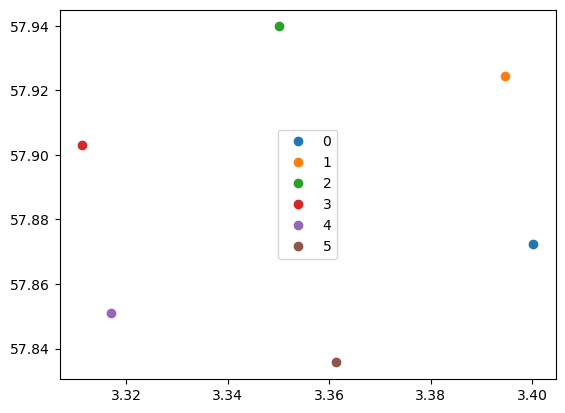

In [9]:
# test if implementation is correct 
print(particle_neighbors[0])
dict_nwes=NWESParticles.lonlat_dict
lontest=dict_nwes['lon'][particle_neighbors[0]]
lattest=dict_nwes['lat'][particle_neighbors[0]]
fig,ax=plt.subplots()
for i in range(0,6,1):
    ax.plot(lontest[i],lattest[i],'o')
ax.legend(np.arange(0,6,1))



In [10]:
indices = np.arange(0,NWESParticles.size,1)
da = xr.DataArray(data =  particle_neighbors, dims = ['indices','neighbor'], coords= dict(indices = indices, neighbor = np.arange(0,6,1)))

## Save mask 

In [11]:
# 
dict_nwes=NWESParticles.lonlat_dict
dict_nwes['region'] = 'NWES'
ds = xr.Dataset(
        dict_nwes
    )   
ds['neighbor_list'] = da
print(ds)
ds.to_netcdf('/storage/shared/oceanparcels/output_data/data_Meike/NWES/NWES_hex_release_new_2.nc')

<xarray.Dataset> Size: 6MB
Dimensions:        (lon: 88347, lat: 88347, indices: 88347, neighbor: 6)
Coordinates:
  * lon            (lon) float64 707kB 3.356 2.353 -15.48 ... -13.99 7.607
  * lat            (lat) float64 707kB 57.89 60.27 58.74 ... 58.45 52.09 54.3
  * indices        (indices) int64 707kB 0 1 2 3 4 ... 88343 88344 88345 88346
  * neighbor       (neighbor) int64 48B 0 1 2 3 4 5
Data variables:
    uber_h3_res    int64 8B 6
    region         <U4 16B 'NWES'
    neighbor_list  (indices, neighbor) int64 4MB 66045 5049 ... 83250 21011
